## Final Model developement 

In [2]:
# Import packages 
import os 
import numpy as np
import pandas as pd
import xarray as xr
os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data
from src.visualize import plot_numerical_distributions, plot_confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score, make_scorer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.cluster import KMeans
from imblearn.over_sampling import KMeansSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

### Data Collection & prepration

In [5]:
## Collect data 
## Model Training data
df = pd.read_csv('data/processed/training_s2_indices.csv', index_col=0)
df.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,tif_path,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,...,data/raw/gee_downloads_train//20240412T050649_...,0.103244,0.169276,-0.137874,0.137874,0.093438,0.089909,0.095105,0.004241,-0.146658
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,...,data/raw/gee_downloads_train//20240425T051649_...,0.196182,0.359014,-0.191513,0.191513,0.157596,0.146604,-0.032861,0.005505,0.027249
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,...,data/raw/gee_downloads_train//20240427T050651_...,0.206604,0.375025,-0.207168,0.207168,0.173276,0.163626,-0.032272,0.013724,0.065676
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,52,...,data/raw/gee_downloads_train//20241103T050951_...,0.205601,0.314560,-0.219299,0.219299,0.171823,0.162070,0.019914,0.012624,0.059579
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,55,...,data/raw/gee_downloads_train//20240517T050651_...,0.204152,0.689947,-0.185398,0.185398,0.185018,0.179114,-0.078713,0.026941,0.129725


In [7]:
# categorical data transformation 
category_mapper = {label: idx for idx, label in enumerate(df['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(df['category'].unique()) if pd.notna(label)}
idx_to_category_mapper

{0: 'Healthy', 1: 'Diseased', 2: 'Pests', 3: 'Stressed'}

In [9]:
df.columns

Index(['FarmID', 'category', 'Crop', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'CropCoveredArea', 'CHeight', 'CNext', 'CLast',
       'CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov',
       'ExpYield', 'Season', 'geometry', 'tif_path', 'NDVI', 'EVI', 'NDWI',
       'GNDVI', 'SAVI', 'MSAVI', 'MoistureIndex', 'NDRE', 'CCCI'],
      dtype='object')

In [75]:
## Data Preprocessing 
df['SDate'] = pd.to_datetime(df.SDate)
df['HDate'] = pd.to_datetime(df.HDate)
df['TDays'] = (df.HDate - df.SDate).dt.days
#df = df[df.TDays < 12*30]
to_drop = ['FarmID', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'geometry', 'tif_path']
train = df.drop(columns=to_drop)
train_data = prepare_model_data(train)

In [77]:
df.shape

(6959, 31)

In [79]:
train_data.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,target
0,5,97,54,4,0,3,1,1,4,87,...,0.169276,-0.137874,0.137874,0.093438,0.089909,0.095105,0.004241,-0.146658,141,0
1,5,82,58,4,0,3,1,0,5,94,...,0.359014,-0.191513,0.191513,0.157596,0.146604,-0.032861,0.005505,0.027249,165,0
2,5,92,91,4,0,3,1,0,3,99,...,0.375025,-0.207168,0.207168,0.173276,0.163626,-0.032272,0.013724,0.065676,131,0
4,5,94,55,4,0,3,1,0,5,97,...,0.689947,-0.185398,0.185398,0.185018,0.179114,-0.078713,0.026941,0.129725,159,1
5,5,97,51,4,0,3,1,1,5,85,...,0.342297,-0.159876,0.159876,0.137544,0.129885,-0.051080,0.033711,0.205249,157,2


#### Train/validation split

In [82]:
corr_matrix = train_data.corr('spearman')
dissimilarity = 1 - abs(corr_matrix.values)

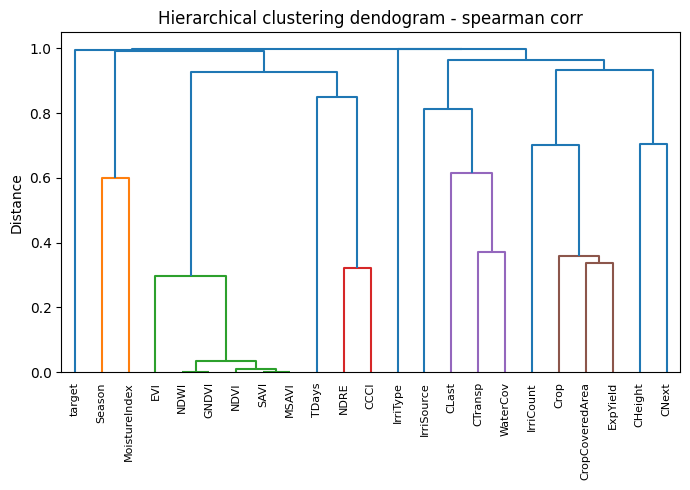

In [84]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# hierarchical clustering based on dissimilarity
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
    labels=corr_matrix.columns.tolist(),
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram - spearman corr')
fig.tight_layout()

In [86]:
threshold = 0.3

cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = len(set(cluster_labels))
print(f'Number of clusters: {n_clusters}')

cluster_features = {}

for label in range(1, n_clusters + 1):
    print(f'Cluster {label}')

    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].to_list()
    print(cluster_features[label])
    print()

Number of clusters: 18
Cluster 1
['Season']

Cluster 2
['MoistureIndex']

Cluster 3
['NDVI', 'EVI', 'NDWI', 'GNDVI', 'SAVI', 'MSAVI']

Cluster 4
['NDRE']

Cluster 5
['CCCI']

Cluster 6
['TDays']

Cluster 7
['target']

Cluster 8
['CTransp']

Cluster 9
['WaterCov']

Cluster 10
['CLast']

Cluster 11
['IrriSource']

Cluster 12
['CropCoveredArea']

Cluster 13
['ExpYield']

Cluster 14
['Crop']

Cluster 15
['IrriCount']

Cluster 16
['CHeight']

Cluster 17
['CNext']

Cluster 18
['IrriType']



In [88]:
cluster_features = [cols[0] for cols in cluster_features.values()]
cluster_features

['Season',
 'MoistureIndex',
 'NDVI',
 'NDRE',
 'CCCI',
 'TDays',
 'target',
 'CTransp',
 'WaterCov',
 'CLast',
 'IrriSource',
 'CropCoveredArea',
 'ExpYield',
 'Crop',
 'IrriCount',
 'CHeight',
 'CNext',
 'IrriType']

In [90]:
train_data.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,target
0,5,97,54,4,0,3,1,1,4,87,...,0.169276,-0.137874,0.137874,0.093438,0.089909,0.095105,0.004241,-0.146658,141,0
1,5,82,58,4,0,3,1,0,5,94,...,0.359014,-0.191513,0.191513,0.157596,0.146604,-0.032861,0.005505,0.027249,165,0
2,5,92,91,4,0,3,1,0,3,99,...,0.375025,-0.207168,0.207168,0.173276,0.163626,-0.032272,0.013724,0.065676,131,0
4,5,94,55,4,0,3,1,0,5,97,...,0.689947,-0.185398,0.185398,0.185018,0.179114,-0.078713,0.026941,0.129725,159,1
5,5,97,51,4,0,3,1,1,5,85,...,0.342297,-0.159876,0.159876,0.137544,0.129885,-0.051080,0.033711,0.205249,157,2


In [92]:
# Separate features and target variable in the train set
#X = train_data.drop(columns=['target'])
X = train_data[cluster_features].drop(columns=['target'])
y = train_data['target'].astype(int)
X.shape, y.shape

((6959, 17), (6959,))

In [ ]:
import warnings
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Example dataset (replace with actual data)
# X, y = your_dataset_features, your_dataset_labels
# Ensure `y` contains integer labels from 0 to num_classes - 1

N_FOLDS = 5

# Function to fit and validate the model
def fit_and_valid_model(X, y, params, num_classes):
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    scores = []

    for train_index, valid_index in cv.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # Train LightGBM with multiclass objective
        model = LGBMClassifier(
            **params,
            class_weight="balanced",
            num_class=4,  # Specify the number of classes
            random_state=42,
            verbose=-1,
        )
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_valid, y_valid)],  # Validation set for early stopping
                  eval_metric="multi_logloss",
                  callbacks=[early_stopping(stopping_rounds=10), log_evaluation(5)]
                 )

        # Predict probabilities for evaluation
        y_pred_proba = model.predict_proba(X_valid)

        # Check if probabilities sum to 1 for each row
        if not np.allclose(np.sum(y_pred_proba, axis=1), 1.0):
            raise ValueError("Predicted probabilities do not sum to 1.")

        # Calculate ROC AUC for multiclass
        score = roc_auc_score(
            y_valid,
            y_pred_proba,
            multi_class="ovr",  # Specify one-vs-rest (ovr) strategy
            average="macro"
        )
        scores.append(score)

    return np.mean(scores)

# Optuna objective function
def optuna_objective(trial: optuna.trial.Trial) -> float:
    num_classes = len(np.unique(y))  # Calculate the number of classes
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 24, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 64, log=True),
        "subsample": trial.suggest_float("subsample", 0.25, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-4, 100, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100, log=True),
        "objective": "multiclass"  # Fixed the objective function
    }

    # Run the training and validation
    score = fit_and_valid_model(X, y, params, num_classes)
    return score

# Optuna study
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=optuna.exceptions.ExperimentalWarning)
    study = optuna.create_study(direction="maximize", study_name="lightgbm")

    # Optimize
    study.optimize(optuna_objective, timeout=7200, n_trials=50)

# Display best parameters and score
print("Best parameters:", study.best_params)
print("Best ROC AUC score (macro):", study.best_value)

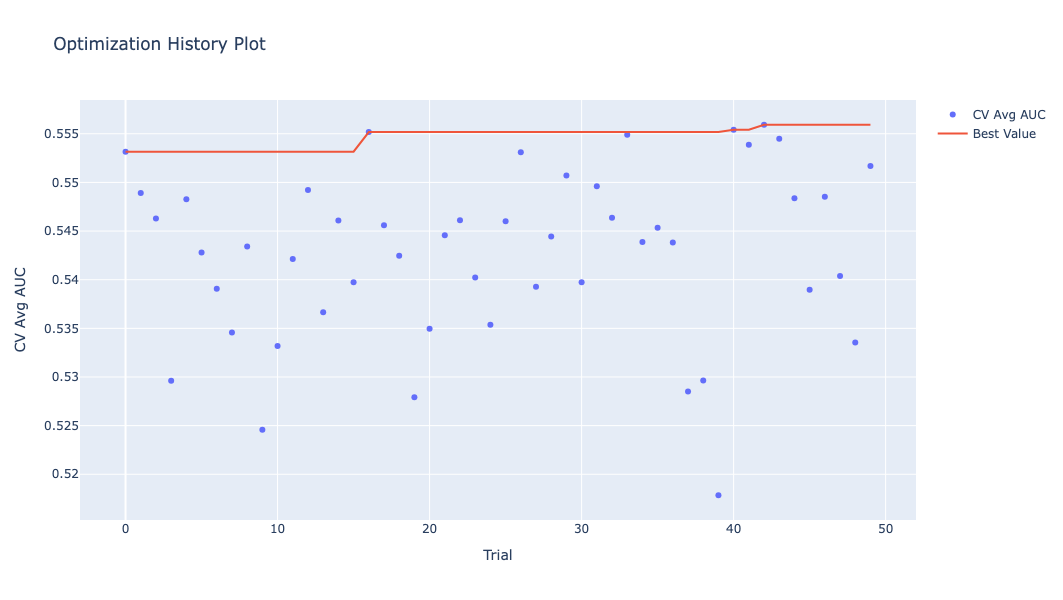

In [97]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV Avg AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

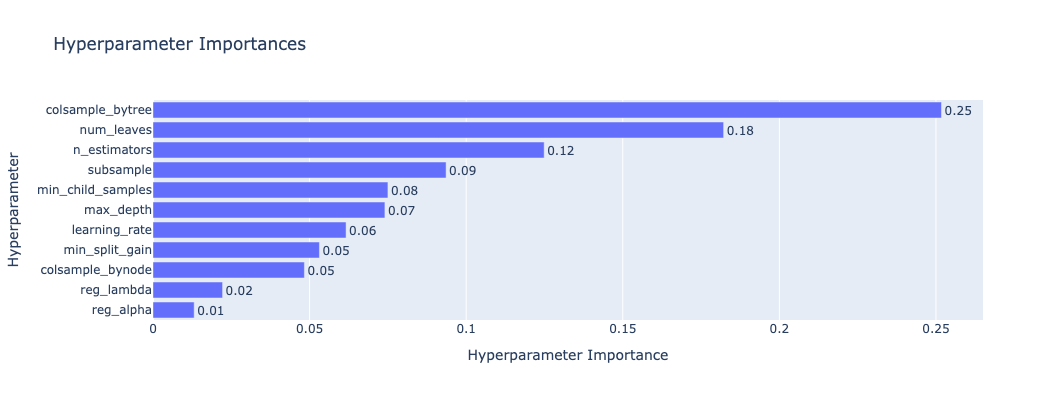

In [99]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=900,
    height=400
)
fig.show()

In [101]:
study.best_params

{'n_estimators': 249,
 'learning_rate': 0.01746426728858227,
 'max_depth': 9,
 'num_leaves': 2,
 'subsample': 0.993906627478148,
 'colsample_bytree': 0.4547457713757653,
 'colsample_bynode': 0.9086634718214998,
 'reg_alpha': 0.012471449885660778,
 'reg_lambda': 3.3246399401279993,
 'min_split_gain': 3.562716847823201,
 'min_child_samples': 25}

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
model_g = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    verbose=-1,
    n_jobs=-1,
    **study.best_params
).fit(X_train, y_train)

In [105]:
# Evaluate the model
y_pred = model_g.predict(X_valid)
print(classification_report(y_valid, y_pred))
f1 = f1_score(y_valid, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1438
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00        95

    accuracy                           0.83      1740
   macro avg       0.21      0.25      0.23      1740
weighted avg       0.68      0.83      0.75      1740


Weighted F1 Score: 0.747901882916314


/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



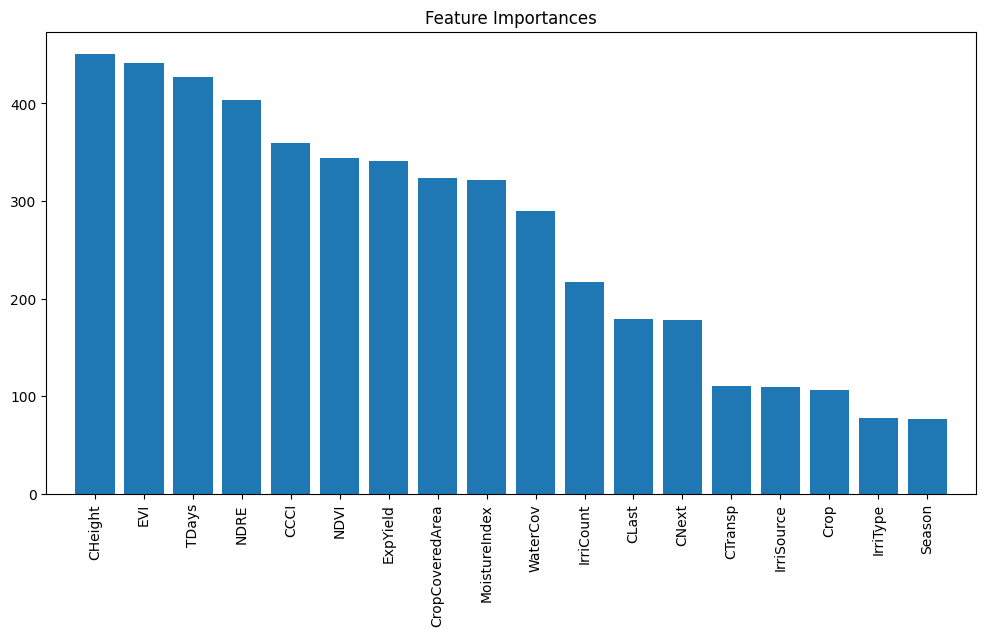

In [71]:
# Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

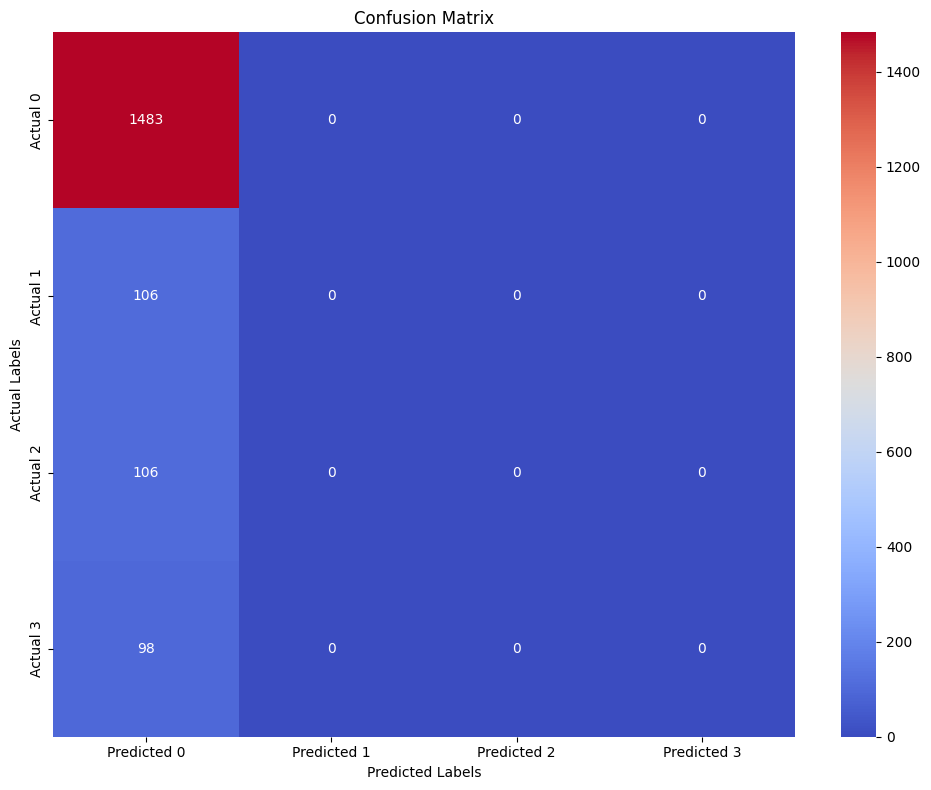

In [73]:
plot_confusion_matrix(y_valid, y_pred, normalize=True, title="Confusion Matrix")

In [ ]:
import shap

In [ ]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

## Model Training & Validation

### Balanced Random Forest Model

In [126]:
brf = BalancedRandomForestClassifier(n_estimators=500, 
                                     max_depth=30,
                                     min_samples_split=4,
                                     random_state=42,
                                    )
brf.fit(X_train, y_train)


# Evaluate the model
y_pred = brf.predict(X_valid)
print(classification_report(y_valid, y_pred))
f1 = f1_score(y_valid, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)

              precision    recall  f1-score   support

           0       0.84      0.58      0.69      1050
           1       0.14      0.31      0.19        77
           2       0.05      0.13      0.07        75
           3       0.04      0.10      0.06        69

    accuracy                           0.51      1271
   macro avg       0.27      0.28      0.25      1271
weighted avg       0.71      0.51      0.59      1271


Weighted F1 Score: 0.5856716006741445


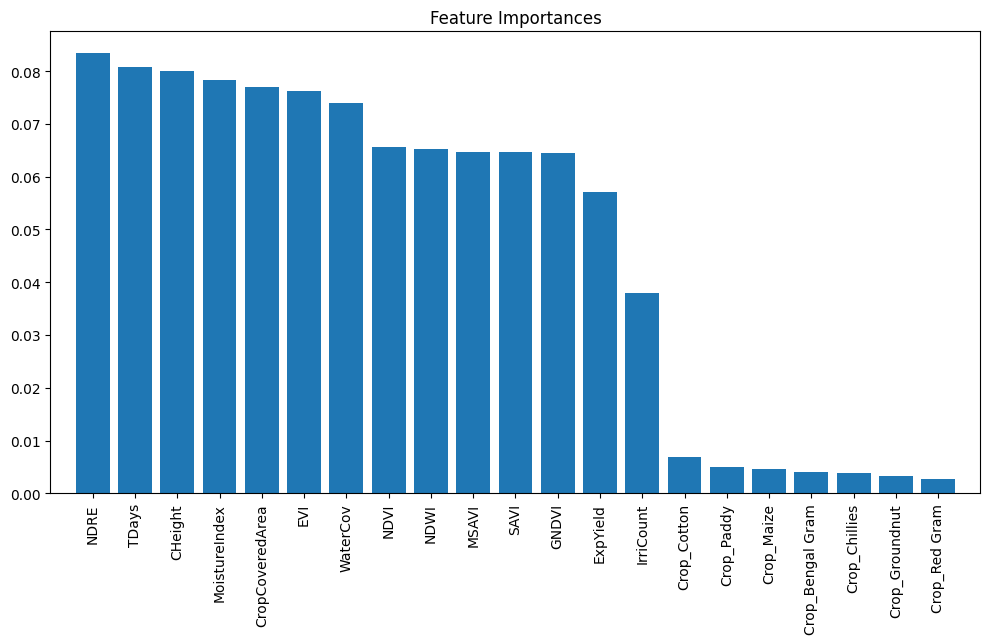

In [128]:
# Feature Importance Plot
importances = brf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

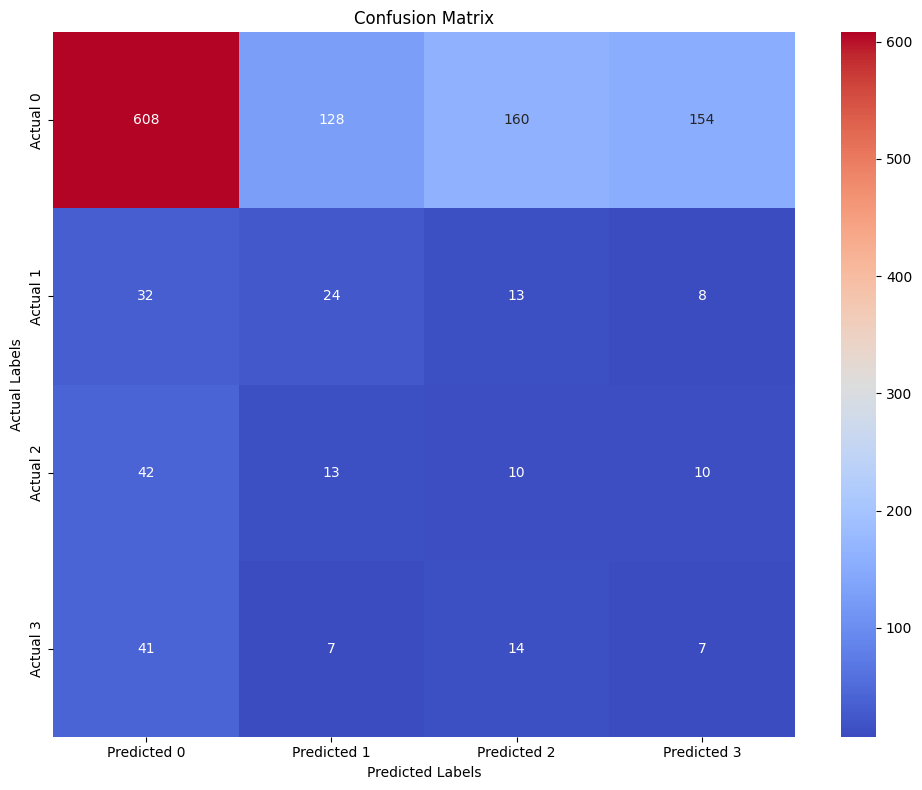

In [130]:
plot_confusion_matrix(y_valid, y_pred, normalize=True, title="Confusion Matrix")

In [132]:
brf.predict_proba(train_data.drop(columns=['target']))

array([[0.38966667, 0.23933333, 0.15      , 0.221     ],
       [0.36833333, 0.11333333, 0.25766667, 0.26066667],
       [0.38366667, 0.18666667, 0.20266667, 0.227     ],
       ...,
       [0.39866667, 0.19533333, 0.22133333, 0.18466667],
       [0.339     , 0.11966667, 0.239     , 0.30233333],
       [0.37733333, 0.122     , 0.27266667, 0.228     ]])

### LGBM Model

In [175]:
lgbm = LGBMClassifier(
    class_weight='balanced',
    max_depth = 30, 
    learning_rate = 0.05,
    n_estimators = 200,
    force_col_wise = True,
    random_state=42,)

lgbm.fit(X_train, y_train, eval_set = (X_valid, y_valid))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 5084, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', force_col_wise=True, learning_rate=0.05,
               max_depth=30, n_estimators=200, random_state=42)

In [177]:
# Predict on the validation set
y_pred = lgbm.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.84      0.87      0.85      1050
    Diseased       0.14      0.13      0.13        77
       Pests       0.10      0.08      0.09        75
    Stressed       0.04      0.03      0.03        69

    accuracy                           0.73      1271
   macro avg       0.28      0.28      0.28      1271
weighted avg       0.71      0.73      0.72      1271


Weighted F1 Score: 0.718771925942331


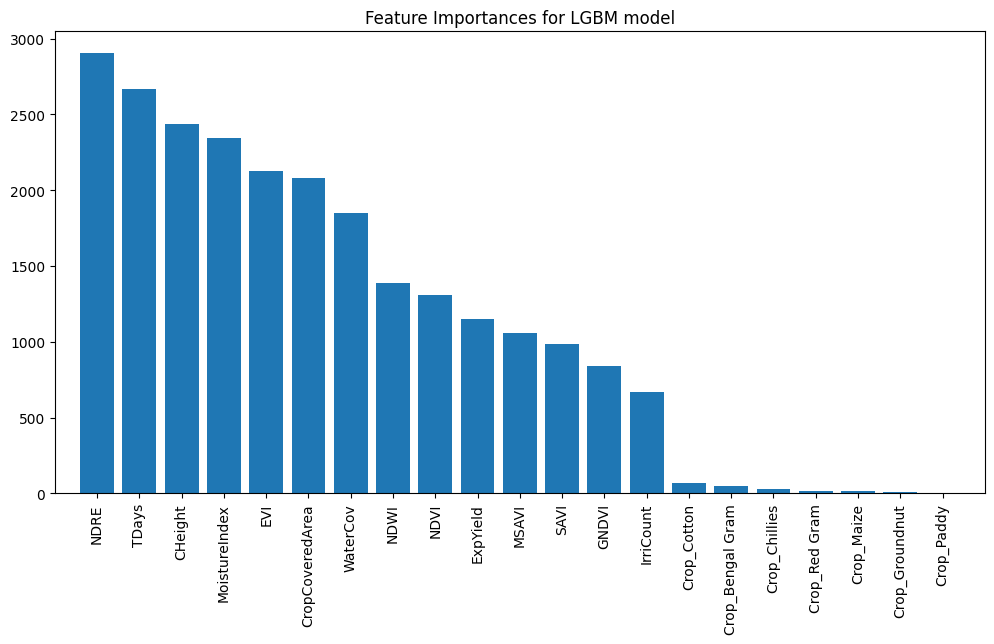

In [179]:
# Feature Importance Plot
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances for LGBM model')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

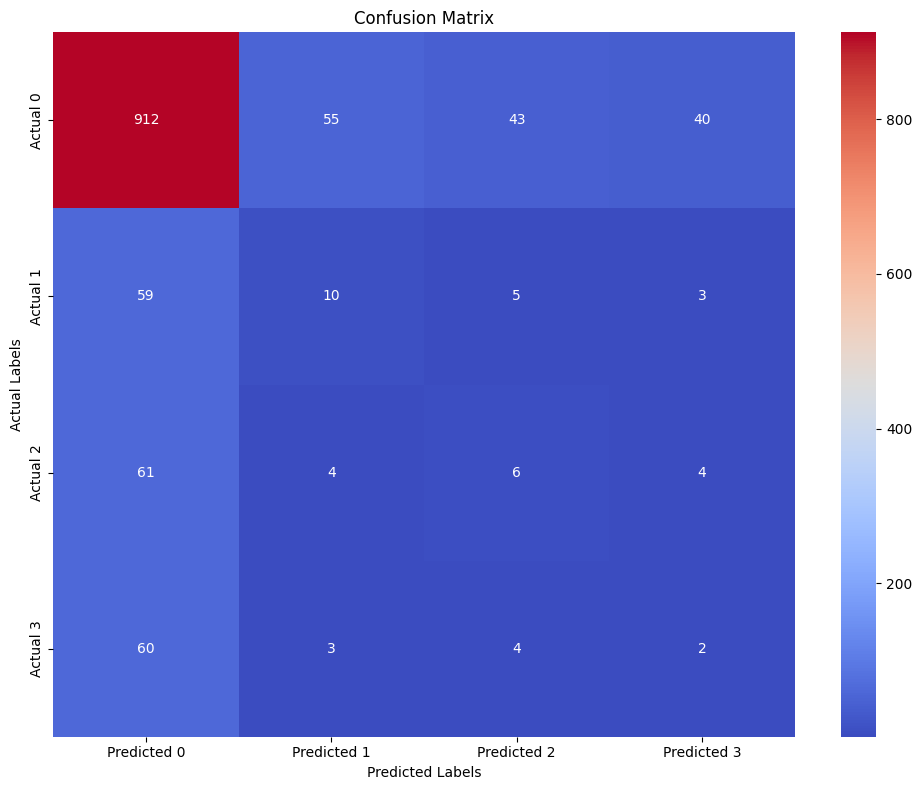

In [181]:
plot_confusion_matrix(y_valid, y_pred, normalize=True, title="Confusion Matrix")

## Ensemble Model

In [183]:
from sklearn.multiclass import OneVsRestClassifier
ov_classifier = OneVsRestClassifier(lgbm)

In [185]:
ov_classifier.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4198, number of negative: 886
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 5084, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 308, number of negative: 4776
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 5084, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 302, number of negative: 4782
[LightGBM] [Info] Total Bins 2671
[L

OneVsRestClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                             force_col_wise=True,
                                             learning_rate=0.05, max_depth=30,
                                             n_estimators=200,
                                             random_state=42))

In [187]:
# Predict on the validation set
y_pred = ov_classifier.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.90      0.86      1050
    Diseased       0.19      0.12      0.14        77
       Pests       0.11      0.07      0.08        75
    Stressed       0.05      0.03      0.04        69

    accuracy                           0.75      1271
   macro avg       0.29      0.28      0.28      1271
weighted avg       0.70      0.75      0.73      1271


Weighted F1 Score: 0.7264812163899429


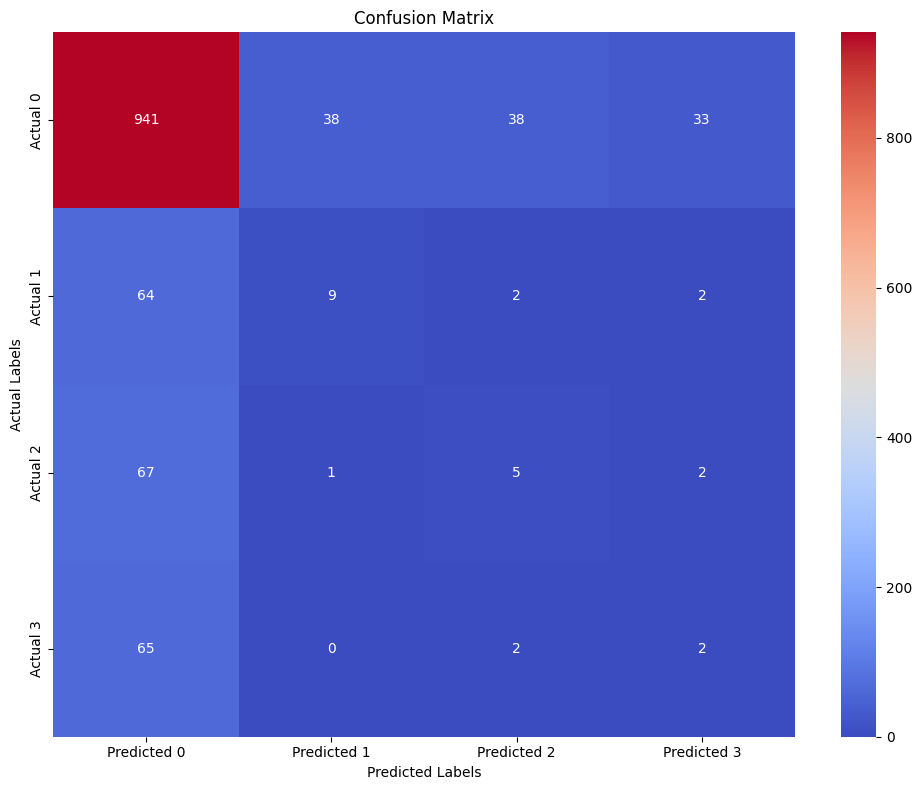

In [189]:
plot_confusion_matrix(y_valid, y_pred, normalize=True, title="Confusion Matrix")

## Model Test & Submission

In [101]:
t_data = pd.read_csv('data/processed/test_s2_indices.csv', index_col=0)
t_data.rename(columns={'Target': 'category'}, inplace=True)
t_data['CCCI'] = t_data.NDRE/t_data.NDVI
t_data.head()

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,TDays,category,CCCI
0,85197,Paddy,Telangana,Medak,Nizampet,2023-11-12,2024-05-14,81,99,Lentil,...,0.477818,-0.186501,0.186501,0.166871,0.160190,-0.052240,0.018060,184,Healthy,0.096003
1,779677,Paddy,Telangana,Medak,Nizampet,2023-12-20,2024-05-28,91,63,Lentil,...,0.136052,-0.063854,0.063854,0.045236,0.045388,0.295778,0.013461,160,Healthy,0.299717
2,1331840,Paddy,Telangana,Medak,Nizampet,2023-11-29,2024-05-18,94,89,Pea,...,0.199967,-0.114407,0.114407,0.071668,0.069689,0.002065,0.014237,171,Healthy,0.180321
3,483053,Paddy,Telangana,Medak,Nizampet,2023-01-11,2024-04-27,83,78,Pea,...,0.292677,-0.224060,0.224060,0.176058,0.165684,0.090542,0.016683,472,Healthy,0.078465
4,542945,Paddy,Telangana,Medak,Nizampet,2023-04-11,2024-04-25,82,53,Lentil,...,0.369881,-0.234168,0.234168,0.192828,0.183282,0.064641,0.021081,380,Healthy,0.092908


In [103]:
## Data Preprocessing 
t_data['SDate'] = pd.to_datetime(t_data.SDate)
t_data['HDate'] = pd.to_datetime(t_data.HDate)
t_data['TDays'] = (t_data.HDate - t_data.SDate).dt.days
to_drop = ['FarmID', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'geometry', 'tif_path']
test = t_data.drop(columns=to_drop)
test_data = prepare_model_data(test)
test_data.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,TDays,CCCI,target
0,5,81,99,0,4,3,1,1,5,81,...,0.477818,-0.186501,0.186501,0.166871,0.160190,-0.052240,0.018060,184,0.096003,0
1,5,91,63,0,4,3,1,0,5,97,...,0.136052,-0.063854,0.063854,0.045236,0.045388,0.295778,0.013461,160,0.299717,0
2,5,94,89,4,0,3,1,0,5,88,...,0.199967,-0.114407,0.114407,0.071668,0.069689,0.002065,0.014237,171,0.180321,0
3,5,83,78,4,0,3,1,0,5,98,...,0.292677,-0.224060,0.224060,0.176058,0.165684,0.090542,0.016683,472,0.078465,0
4,5,82,53,0,4,3,1,0,6,98,...,0.369881,-0.234168,0.234168,0.192828,0.183282,0.064641,0.021081,380,0.092908,0


In [105]:
test_data.fillna(test_data.mean(), inplace=True)
test_data = test_data[cluster_features]
test_data.drop(columns=['target'], inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 2717
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NDVI             2718 non-null   float64
 1   EVI              2718 non-null   float64
 2   NDRE             2718 non-null   float64
 3   CCCI             2718 non-null   float64
 4   TDays            2718 non-null   int64  
 5   Season           2718 non-null   int64  
 6   MoistureIndex    2718 non-null   float64
 7   CTransp          2718 non-null   int64  
 8   WaterCov         2718 non-null   int64  
 9   CLast            2718 non-null   int64  
 10  IrriSource       2718 non-null   int64  
 11  CropCoveredArea  2718 non-null   int64  
 12  ExpYield         2718 non-null   int64  
 13  Crop             2718 non-null   int64  
 14  IrriCount        2718 non-null   int64  
 15  CHeight          2718 non-null   int64  
 16  CNext            2718 non-null   int64  
 17  IrriType         27

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_82208/546214617.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [107]:
test_data.head()

,NDVI,EVI,NDRE,CCCI,TDays,Season,MoistureIndex,CTransp,WaterCov,CLast,IrriSource,CropCoveredArea,ExpYield,Crop,IrriCount,CHeight,CNext,IrriType
0,0.188120,0.477818,0.018060,0.096003,184,1,-0.052240,3,81,4,1,81,19,5,5,99,0,1
1,0.044911,0.136052,0.013461,0.299717,160,1,0.295778,3,97,4,0,91,15,5,5,63,0,1
2,0.078955,0.199967,0.014237,0.180321,171,1,0.002065,3,88,0,0,94,15,5,5,89,4,1
3,0.212621,0.292677,0.016683,0.078465,472,1,0.090542,3,98,0,0,83,17,5,5,78,4,1
4,0.226900,0.369881,0.021081,0.092908,380,1,0.064641,3,98,4,0,82,18,5,6,53,0,1


In [191]:
# Predict submission
rf_predictions = brf.predict(test_data)
rf_predictions

array([0, 1, 1, ..., 1, 0, 0])

In [193]:
pd.DataFrame(rf_predictions).value_counts()

0    1651
2     382
1     366
3     319
Name: count, dtype: int64

In [195]:
# Predict submission
lg_predictions = lgbm.predict(test_data)
pd.DataFrame(lg_predictions).value_counts()

0    2432
1     101
3      95
2      90
Name: count, dtype: int64

In [109]:
# Predict submission
f_predictions = model.predict(test_data)
pd.DataFrame(f_predictions).value_counts()

0    2718
Name: count, dtype: int64

In [144]:
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

In [146]:
t_data['Target'] = f_predictions
t_data['Target'] = t_data['Target'].astype(int).map(idx_to_category_mapper)
subm_df = t_data[['FarmID', 'Target']]
subm_df.head()

,FarmID,Target
0,85197,Healthy
1,779677,Healthy
2,1331840,Healthy
3,483053,Healthy
4,542945,Healthy


In [148]:
subm_df.groupby(['Target']).count()

,FarmID
Target,
Diseased,155
Healthy,2304
Pests,153
Stressed,106


In [150]:
subm_df.to_csv('data/sub_files/submission_mm2201.csv', index=0)

In [154]:
df.groupby(['category']).count()/3

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays
category,,,,,,,,,,,,,,,,,,,,,
Diseased,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,...,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667,145.666667
Healthy,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,...,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000
Pests,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,...,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333,147.333333
Stressed,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,...,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
